# Data preprocessing

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler


df = pd.read_csv("internet_service_churn.csv")

## 1. Processing missing values

In [8]:
print(df.shape)
print(df.isna().sum())

(72274, 11)
id                                 0
is_tv_subscriber                   0
is_movie_package_subscriber        0
subscription_age                   0
bill_avg                           0
reamining_contract             21572
service_failure_count              0
download_avg                     381
upload_avg                       381
download_over_limit                0
churn                              0
dtype: int64


The columns remaining_contract, download_avg, and upload_avg in our dataset contain missing values. We will analyze each of these columns.

### 1.1 Analyze reamining_contract 

In [9]:
#change all NaN to '0.00'
if "reamining_contract" in df.columns:
    df["reamining_contract"] = df["reamining_contract"].replace(np.nan, 0.00)

count_churn_1 = df[ df['churn'] == 1].shape[0]
count_zero_and_churn_1 = df[(df['reamining_contract'] == 0.00) & (df['churn'] == 1)].shape[0]
count_zero = df[(df['reamining_contract'] == 0.00)].shape[0]

print(f"Number of cases where 'churn' = 1: {count_churn_1}")
print(f"Number of cases where 'reamining_contract' == 0.00 (or NaN): {count_zero}")
print(f"Number of cases where 'reamining_contract' = 0.00 or NaN and 'churn' = 1: {count_zero_and_churn_1}")


percentage_churn_1 = count_zero_and_churn_1/count_churn_1 * 100
percentage_to_all = count_zero/df.shape[0] * 100
print(f"Percentage where churn == 1 and remaining_contract == 0.00 (or NaN): {percentage_churn_1:.2f}%")
print(f"Percentage where remaining_contract == 0.00 (or NaN) to all cases: {percentage_to_all:.2f}%")

Number of cases where 'churn' = 1: 40050
Number of cases where 'reamining_contract' == 0.00 (or NaN): 37935
Number of cases where 'reamining_contract' = 0.00 or NaN and 'churn' = 1: 36010
Percentage where churn == 1 and remaining_contract == 0.00 (or NaN): 89.91%
Percentage where remaining_contract == 0.00 (or NaN) to all cases: 52.49%


1. It can be concluded that in 90% of cases, if the "churn" column == 1, the "reamining_contract" will be either 0.00 (or NaN). It looks like the "reamining_contract" data is removing for some reason when a client breaks the contract. So we don't have data regarding the contract duration if the contract was already breaked for most of the cases.
2. The percentage of cases with lack of remaining_contract data (0.00 or NaN) to all cases is 52.5%.

Concludions: I believe that "reamining_contract" can be removed because of lack of a lot of data

### 1.2 Analyze download_avg and upload_avg

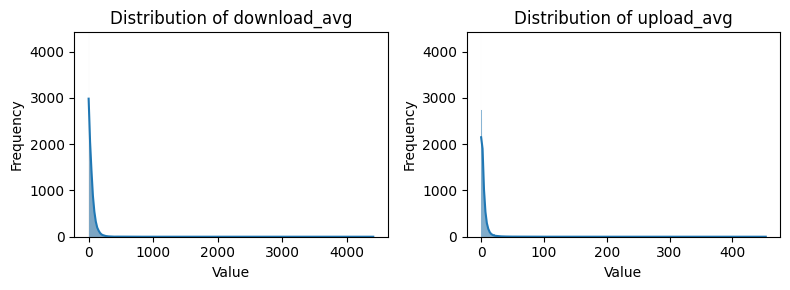

In [10]:
сolumns_to_fill = ["download_avg", "upload_avg"]

max_value = max(df["download_avg"].max(), df["upload_avg"].max())


fig, axes = plt.subplots(1, 2, figsize=(8, 3))

for ax, column in zip(axes, сolumns_to_fill):
    sns.histplot(df[column], kde=True, ax=ax)
    ax.set_title(f"Distribution of {column}")
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")
    ax.set_ylim(0, max_value) 

plt.tight_layout() 
plt.show()

The plots indicate the presence of outliers in the columns. Therefore, it would be safer to replace NaN values with the median value.

In [11]:
for column in сolumns_to_fill:
    df[column] = df[column].fillna(df[column].median())

print(df.isna().sum())

id                             0
is_tv_subscriber               0
is_movie_package_subscriber    0
subscription_age               0
bill_avg                       0
reamining_contract             0
service_failure_count          0
download_avg                   0
upload_avg                     0
download_over_limit            0
churn                          0
dtype: int64


Removing incomplete data ("reamining_contract") and data that will not be used ("id")

In [12]:
columns_to_drop = ["reamining_contract", "id"]
df = df.drop(columns=columns_to_drop, errors='ignore')

df.head()

,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,1,0,11.95,25,0,8.4,2.3,0,0
1,0,0,8.22,0,0,0.0,0.0,0,1
2,1,0,8.91,16,0,13.7,0.9,0,1
3,0,0,6.87,21,1,0.0,0.0,0,1
4,0,0,6.39,0,0,0.0,0.0,0,1


## 2. Encoding categorical variables: One-Hot Encoding або Label Encoding

In our scenario, the categorical variables (is_tv_subscriber, is_movie_package_subscriber) have binary values (0 or 1). Thus, using  One-Hot Encoding or Label Encoding for these variables is unnecessary.

## 3. Normalization of features: Standardization

Binary features (is_tv_subscriber and is_movie_package_subscriber) represent values 1 and 0, which are already normalized within a fixed range. Standardizing these features is unnecessary because it doesn't improve their scale and can distort their interpretation. 

### Data visualization continuous features

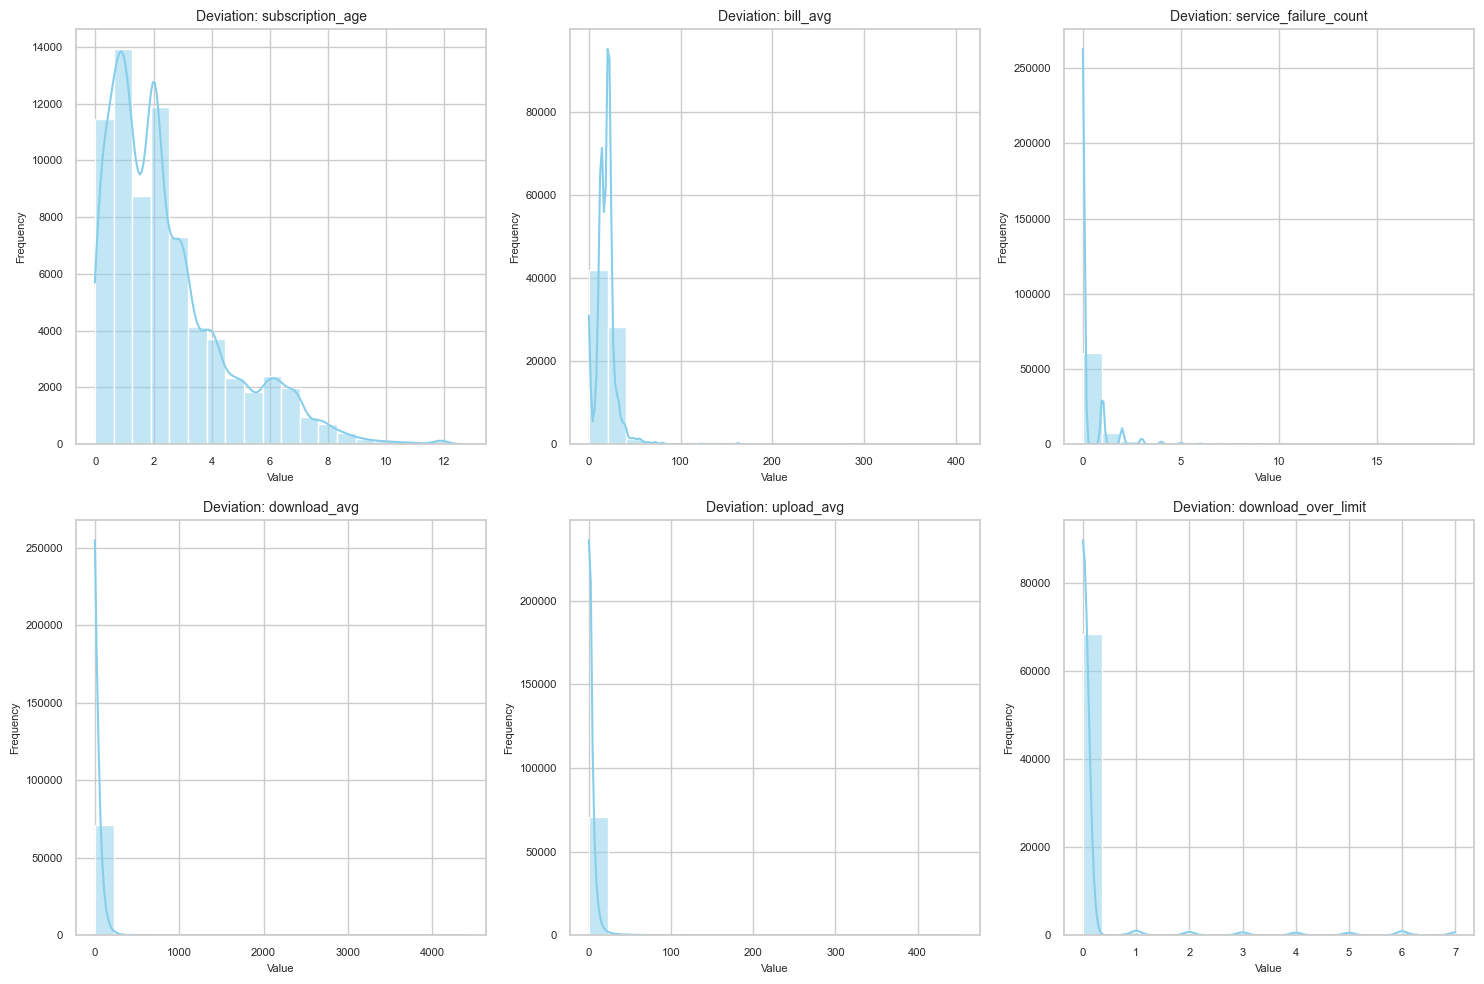

In [13]:
columns_to_filter = ["subscription_age", "bill_avg", "service_failure_count", "download_avg", "upload_avg", "download_over_limit"]

sns.set(style="whitegrid")  

n_rows = (len(columns_to_filter) + 2) // 3

plt.figure(figsize=(15, 5 * n_rows))


for i, column_name in enumerate(columns_to_filter):
    plt.subplot(n_rows, 3, i + 1)  
    column_data = df[column_name].dropna()  
    sns.histplot(column_data, kde=True, color="skyblue", bins=20)  
    plt.title(f"Deviation: {column_name}", fontsize=10)
    plt.xlabel("Value", fontsize=8)
    plt.ylabel("Frequency", fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)


plt.tight_layout()

plt.show()

I will employ the Standard Deviation method for "bill_avg" due to their normal distribution as evidenced by the plots. The Interquartile Range (IQR) method will be utilized for the remaining features.

### Detection and removal of outliers in continuous numerical data

In [14]:
columns_to_filter_normal_distribution = ["bill_avg"]
columns_to_filter = ["service_failure_count", "download_avg", "upload_avg", "download_over_limit", "subscription_age"]

for column in columns_to_filter:
    Q1 = df[column].quantile(0.25)  
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1  
        
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
        
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]


for column in columns_to_filter_normal_distribution:
    mean = df[column].mean()
    std = df[column].std()

    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std

    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

### Standardization

For "bill_avg" I will use "StandardScaler" due to their normal distribution and "MinMaxScaler" for remaining feutures

In [15]:
columns_scaling = {
    "StandardScaler": ["bill_avg"],
    "MinMaxScaler": ["service_failure_count", "download_over_limit", "is_tv_subscriber", "is_movie_package_subscriber", "subscription_age"]
}

scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler()
}

for scaler_name, columns in columns_scaling.items():
    scaler = scalers[scaler_name] 
    df[columns] = scaler.fit_transform(df[columns]) 

### Data visualization after the standartization

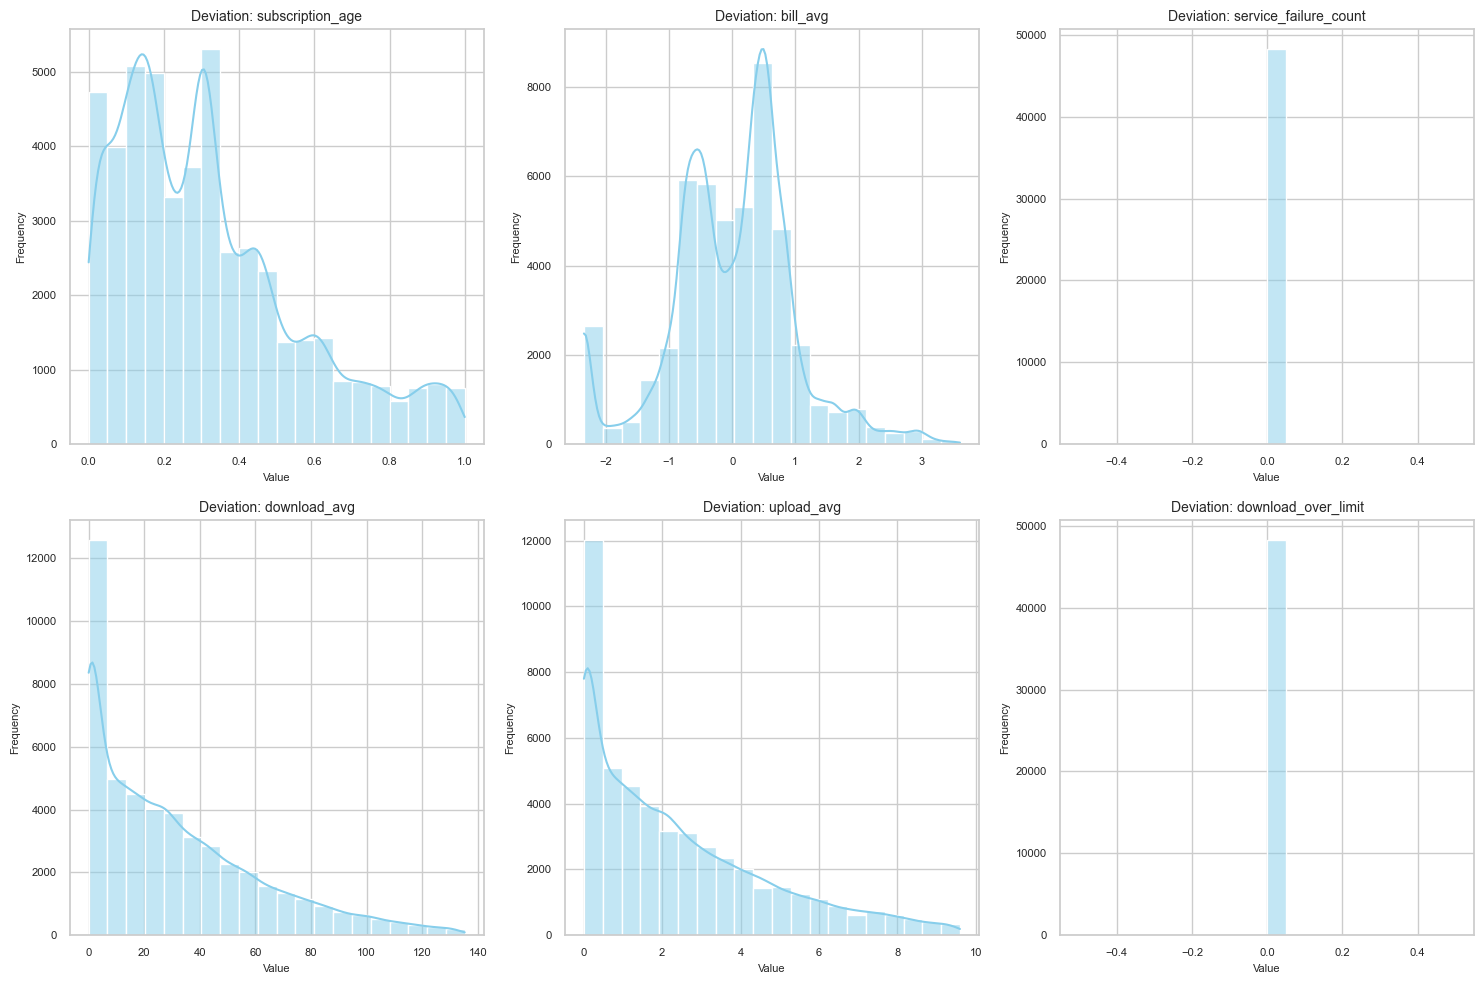

In [16]:
columns_to_filter = ["subscription_age", "bill_avg", "service_failure_count", "download_avg", "upload_avg", "download_over_limit"]

sns.set(style="whitegrid")  

n_rows = (len(columns_to_filter) + 2) // 3

plt.figure(figsize=(15, 5 * n_rows))


for i, column_name in enumerate(columns_to_filter):
    plt.subplot(n_rows, 3, i + 1)  
    column_data = df[column_name].dropna()  
    sns.histplot(column_data, kde=True, color="skyblue", bins=20)  
    plt.title(f"Deviation: {column_name}", fontsize=10)
    plt.xlabel("Value", fontsize=8)
    plt.ylabel("Frequency", fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)


plt.tight_layout()

plt.show()

In [17]:
#saving processed data

df.to_csv("preprocessed_dataset.csv", index=False)